In [ ]:
!unzip '/content/bully_data-20240618T085753Z-001.zip'

Streaming output truncated to the last 5000 lines.
  inflating: bully_data/2142.jpg     
  inflating: bully_data/66.png       
  inflating: bully_data/4.jpg        
  inflating: bully_data/2088.jpg     
  inflating: bully_data/2317.jpg     
  inflating: bully_data/1928.jpg     
  inflating: bully_data/2029.jpg     
  inflating: bully_data/225.jpg      
  inflating: bully_data/2155.jpg     
  inflating: bully_data/113.jpg      
  inflating: bully_data/190.png      
  inflating: bully_data/93.jpg       
  inflating: bully_data/2305.jpg     
  inflating: bully_data/2008.jpg     
  inflating: bully_data/133.jpg      
  inflating: bully_data/164.png      
  inflating: bully_data/2107.jpg     
  inflating: bully_data/2091.jpg     
  inflating: bully_data/264.png      
  inflating: bully_data/216.png      
  inflating: bully_data/16.png       
  inflating: bully_data/1973.jpg     
  inflating: bully_data/28.png       
  inflating: bully_data/2023.jpg     
  inflating: bully_data/159.jpg      

In [ ]:
import pandas as pd
import os
import torch
import torch.nn as nn
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer
from transformers import XLMRobertaModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf

# Load dataset from CSV
df = pd.read_csv('/content/cyberbullying dataset new.csv')

df = df[df['Img_Text_Label'].notnull()]

# Ensure the image paths are correct
df['Img_Name'] = df['Img_Name'].fillna('').astype(str)
df['Image_Path'] = df['Img_Name'].apply(lambda x: os.path.join('/content/bully_data/', x) if x else None)
df = df[df['Image_Path'].notnull()]
# df = df[:1000]

# Tokenizer for XLM-R
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Load VGG16 model (pretrained feature extractor)
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/FINAL VGG16.keras')
vgg16_feature_extractor = tf.keras.Model(
    inputs=vgg16_model.input,
    outputs=vgg16_model.get_layer('dense').output
)

# Preprocess images
image_preprocessor = tf.keras.applications.vgg16.preprocess_input

# Define dataset class
import os

class MultimodalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, tokenizer, image_preprocessor, vgg_model):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.image_preprocessor = image_preprocessor
        self.vgg_model = vgg_model

        # Label mapping (map string labels to integers)
        self.label_map = {'Nonbully': 0, 'Bully': 1}

        # Define a consistent feature size for the image features (e.g., 1024)
        self.image_feature_dim = 1024  # Make sure the final output size is fixed

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load and preprocess image
        image_path = self.image_paths[idx]
        if not os.path.exists(image_path):
            # print(f"Image not found: {image_path}")
            image_features = torch.zeros(self.image_feature_dim)  # Return zeroed tensor if image is missing
        else:
            try:
                image = Image.open(image_path)  # Open image with PIL
                image = image.resize((224, 224))  # Resize image to match VGG16 input size
                image = tf.keras.preprocessing.image.img_to_array(image)
                image = self.image_preprocessor(image)
                image = tf.expand_dims(image, axis=0)  # Add batch dimension
                image_features = self.vgg_model(image, training=False).numpy().squeeze()

                # Ensure the output feature size is consistent (e.g., 1024)
                image_features = torch.tensor(image_features[:self.image_feature_dim], dtype=torch.float32)
            except (UnidentifiedImageError, IOError) as e:
                # print(f"Error loading image {image_path}: {e}")
                image_features = torch.zeros(self.image_feature_dim)  # Return zeroed tensor if image fails to load

        # Tokenize text
        text = self.texts[idx]
        encoded_text = self.tokenizer(text, padding='max_length', truncation=True, max_length=50, return_tensors='pt')

        # Map the label to integer
        label = self.label_map[self.labels[idx]]  # Convert string label to integer

        return (
            image_features,  # Image features are now consistently sized
            encoded_text['input_ids'].squeeze(0),
            encoded_text['attention_mask'].squeeze(0),
            torch.tensor(label, dtype=torch.long),
        )



# Split dataset (80% train, 20% validation)
train_paths, val_paths, train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Image_Path'].tolist(), df['Img_Text'].tolist(), df['Img_Text_Label'].tolist(), test_size=0.2, random_state=42
)

# Create train and validation datasets
train_dataset = MultimodalDataset(train_paths, train_texts, train_labels, tokenizer, image_preprocessor, vgg16_feature_extractor)
val_dataset = MultimodalDataset(val_paths, val_texts, val_labels, tokenizer, image_preprocessor, vgg16_feature_extractor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define Multimodal Model with CustomXLMGRUTransformer
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_feature_dim=1024, combined_dim=512, num_labels=2):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_fc = nn.Linear(image_feature_dim, combined_dim)  # Reduce image features
        self.fc = nn.Linear(combined_dim * 2, num_labels)  # Final classification layer

    def forward(self, image_features, input_ids, attention_mask):
        # Process text through `text_model`
        text_features = self.text_model(input_ids, attention_mask)

        # Reduce image features
        image_features = self.image_fc(image_features)

        # Concatenate features
        combined_features = torch.cat((image_features, text_features), dim=1)
        logits = self.fc(combined_features)
        return logits


# Initialize CustomXLMGRUTransformer for text processing
class CustomXLMGRUTransformer(nn.Module):
    def __init__(self, hidden_size=512, combined_dim=512, dropout_rate=0.5):
        super(CustomXLMGRUTransformer, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.text_fc = nn.Linear(hidden_size * 2, combined_dim)  # Reduce to `combined_dim`
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask=None):
        # Process through XLM-RoBERTa
        text_output = self.xlm_roberta(input_ids, attention_mask=attention_mask)
        text_embeddings = text_output.last_hidden_state

        # GRU processing
        gru_output, _ = self.gru(text_embeddings)
        gru_output = gru_output[:, -1, :]  # Last hidden state

        # Reduce to `combined_dim`
        text_features = self.text_fc(self.dropout(gru_output))
        return text_features  # Shape: (batch_size, combined_dim)


# Initialize models
text_model = CustomXLMGRUTransformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_model.to(device)

multimodal_model = MultimodalClassifier(text_model=text_model)
multimodal_model.to(device)

# Optimizer and Loss
optimizer = torch.optim.AdamW(multimodal_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training Loop
epochs = 10
for epoch in range(epochs):
    multimodal_model.train()
    train_loss = 0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        images, input_ids, attention_mask, labels = batch
        images, input_ids, attention_mask, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()
        logits = multimodal_model(images, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_predictions)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    multimodal_model.eval()
    val_loss = 0
    val_predictions, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            images, input_ids, attention_mask, labels = batch
            images, input_ids, attention_mask, labels = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            logits = multimodal_model(images, input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_predictions)
    print(f"Epoch {epoch + 1}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Epoch 1/10: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 1, Train Loss: 0.5977, Train Accuracy: 0.6975
Epoch 1, Val Loss: 0.5494, Val Accuracy: 0.7100


Epoch 2/10: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 2, Train Loss: 0.5687, Train Accuracy: 0.7225
Epoch 2, Val Loss: 0.5537, Val Accuracy: 0.7000


Epoch 3/10: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Epoch 3, Train Loss: 0.5494, Train Accuracy: 0.7212
Epoch 3, Val Loss: 0.5563, Val Accuracy: 0.7000


Epoch 4/10: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Epoch 4, Train Loss: 0.5363, Train Accuracy: 0.7400
Epoch 4, Val Loss: 0.5492, Val Accuracy: 0.7100


Epoch 5/10: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Epoch 5, Train Loss: 0.5413, Train Accuracy: 0.7312
Epoch 5, Val Loss: 0.5404, Val Accuracy: 0.7150


Epoch 6/10: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Epoch 6, Train Loss: 0.5338, Train Accuracy: 0.7325
Epoch 6, Val Loss: 0.5312, Val Accuracy: 0.7150


Epoch 7/10: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 7, Train Loss: 0.4973, Train Accuracy: 0.7675
Epoch 7, Val Loss: 0.5326, Val Accuracy: 0.7150


Epoch 8/10: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 8, Train Loss: 0.4709, Train Accuracy: 0.7875
Epoch 8, Val Loss: 0.5447, Val Accuracy: 0.7200


Epoch 9/10: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch 9, Train Loss: 0.4024, Train Accuracy: 0.8225
Epoch 9, Val Loss: 0.5553, Val Accuracy: 0.7550


Epoch 10/10: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 10, Train Loss: 0.3423, Train Accuracy: 0.8625
Epoch 10, Val Loss: 0.5993, Val Accuracy: 0.7250


In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    val_predictions, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            images, input_ids, attention_mask, labels = batch
            images, input_ids, attention_mask, labels = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            logits = model(images, input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    overall_accuracy = accuracy_score(val_labels, val_predictions)
    return overall_accuracy

In [ ]:
val_accuracy = evaluate_model(multimodal_model, val_loader)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Validation Accuracy: 0.7400


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader):
    model.eval()
    val_predictions, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            images, input_ids, attention_mask, labels = batch
            images, input_ids, attention_mask, labels = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            logits = model(images, input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    overall_accuracy = accuracy_score(val_labels, val_predictions)

    # Compute confusion matrix
    cm = confusion_matrix(val_labels, val_predictions)

    # Print confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Nonbully", "Bully"], yticklabels=["Nonbully", "Bully"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return overall_accuracy


Confusion Matrix:
 [[ 29  33]
 [ 22 116]]


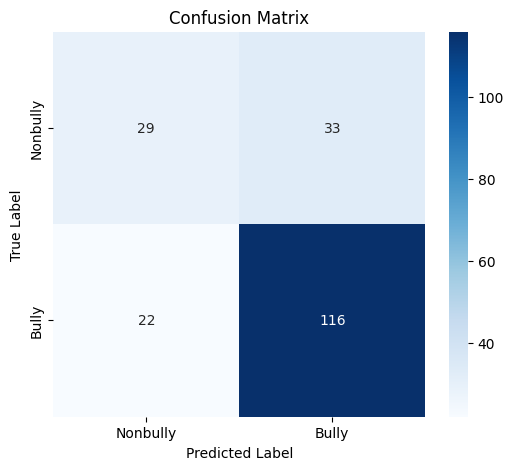

Final Validation Accuracy: 0.7250


In [ ]:
val_accuracy = evaluate_model(multimodal_model, val_loader)
# print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Saving Model

In [ ]:
torch.save(multimodal_model, '/content/drive/MyDrive/multimodal_model_full.pth')